# SV model with variational particle filter

In [1]:
import matplotlib.pyplot as plt
import torch

from ptvi.fivo import *
import ptvi

In [2]:
torch.manual_seed(123)
T = 200
prop = AR1Proposal(0, .95, 2.)
print(prop)

AR(1) proposals:
	z_t = 0.00 + 0.95 * z_{t-1} + η_t
	η_t ~ Ν(0,2.00)


In [12]:
model = ptvi.FilteredStochasticVolatilityModel(
    input_length=T, proposal=prop, num_particles=100, resample=False)
model

Stochastic volatility model:
	x_t = exp(a * z_t/2) ε_t      t=1, …, 200
	z_t = b + c * z_{t-1} + ν_t,  t=2, …, 200
	z_1 ~ N(b, sqrt(1/(1 - c^2)))
	where ε_t, ν_t ~ Ν(0,1)

In [13]:
params = dict(a=1., b=0., c=.95)
y, z_true = model.simulate(**params)

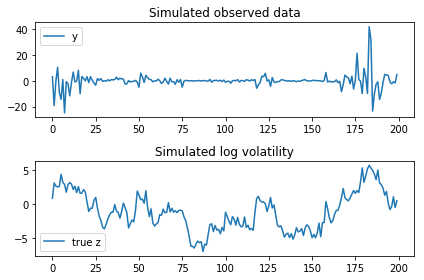

In [14]:
plt.subplot(211); plt.plot(y.numpy(), label='y')
plt.title('Simulated observed data')
plt.legend();
plt.subplot(212); plt.plot(z_true.numpy(), label='true z')
plt.legend()
plt.title('Simulated log volatility');
plt.tight_layout()

In [15]:
fit = ptvi.sgvb(model, y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference: Particle filtered stochastic volatility model
  - Estimating elbo with M=1;
  - Minimum supremum growth heuristic (min_steps=500, patience=20, skip=10, ε=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo =-1184.87
       1. smoothed elbo =-1142.61
       2. smoothed elbo =-1123.62
       4. smoothed elbo =-1080.24
       8. smoothed elbo =-1047.68
      16. smoothed elbo =-1070.26
      32. smoothed elbo = -953.48
      64. smoothed elbo = -995.59
     128. smoothed elbo = -938.73


KeyboardInterrupt: 

In [ ]:
fit.plot_elbos()

In [ ]:
fit.summary(true=params)

In [ ]:
fit.plot_global_marginals(**params)

In [ ]:
fit.plot_latent(N=50, true_z=z_true)

In [ ]:
fit.plot_pred_ci(N=50, α=.1, true_y=y, fc_steps=20)

In [ ]:
model_nors = ptvi.FilteredStochasticVolatilityModel(
    input_length=T, proposal=prop, num_particles=10)
mapfit = ptvi.map(model_nors, y)